### Setup

In [14]:
%pip -q install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.datasets import mnist
from keras.models import Model
from keras.callbacks import EarlyStopping


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    # array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def to_rgb(array, labels):
    """Converts the supplied array to an RGB image."""
    new_array = np.zeros((array.shape[0], 28, 28, 3))
    
    for i in range(len(array)):
        if labels[i] % 2 == 0:
            new_array[i, :, :, 2] = array[i] # blue channel
        else:
            new_array[i, :, :, 0] = array[i] # red channel

    return new_array

    

2024-09-23 14:59:37.166619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 14:59:37.285882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 14:59:37.333694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 14:59:37.347803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 14:59:37.428835: I tensorflow/core/platform/cpu_feature_guar

In [3]:
class VisualizeValidationCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_data, frequency=1):
        self.validation_data = validation_data
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency != 0:
            return
        
        val_samples = self.validation_data[0:2]

        predictions = self.model.predict(val_samples)

        fig, axes = plt.subplots(2, 2, figsize=(10, 8))

        for i in range(2):
            axes[i, 0].imshow(val_samples[i].squeeze(), cmap='gray')
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(predictions[i].squeeze(), cmap='gray')
            axes[i, 1].set_title('Reconstructed')
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()
        

### Prepare the data

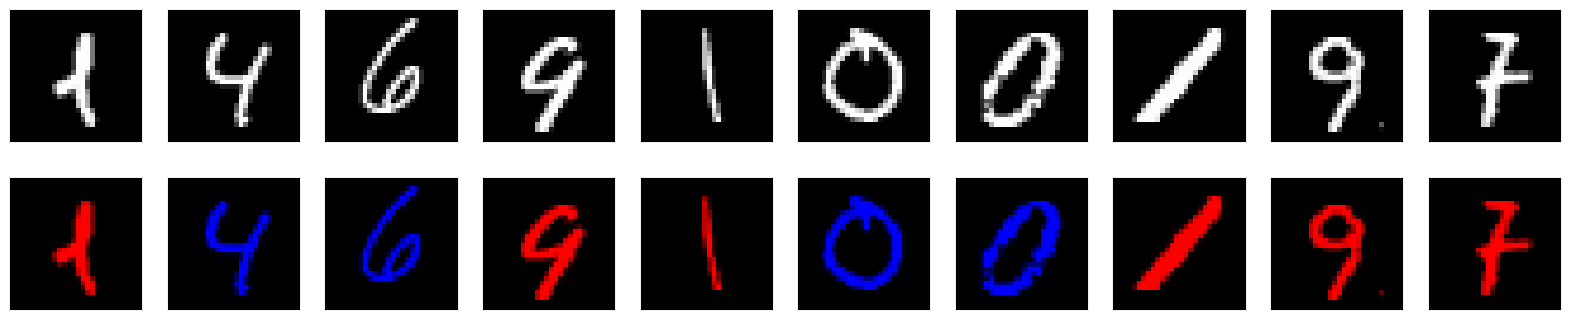

In [4]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, train_label), (test_data, test_label) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
color_train_data = to_rgb(train_data, train_label)
color_test_data = to_rgb(test_data, test_label)

callback = VisualizeValidationCallback(test_data, frequency=20)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Display the train data and a version of it with added noise
display(train_data, color_train_data)

### Build the autoencoder

In [5]:
input = layers.Input(shape=(28, 28, 1))

### Melhor resultado - 100 epochs
# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.BatchNormalization()(x) # Melhorar a estabilidade do treinamento, evitando overfitting
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x) # Melhorar a estabilidade do treinamento, evitando overfitting
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x) # Coloquei mais uma camada de convolução

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (5, 5), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x) # Coloquei mais uma camada de convolução
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x) # Put filters=3 for RGB

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

I0000 00:00:1727114387.927243   35059 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 14:59:48.010891: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        25,632 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,203 (278.14 KB)

 Trainable params: 71,075 (277.64 KB)

 Non-trainable params: 128 (512.00 B)

Now we can train our autoencoder using train_data as both our input data and target. Notice we are setting up the validation data using the same format.

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - loss: 0.1142 - val_loss: 0.0628
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0357 - val_loss: 0.0329
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0317 - val_loss: 0.0313
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0297 - val_loss: 0.0294
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0286 - val_loss: 0.0284
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0276 - val_loss: 0.0326
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0273 - val_loss: 0.0272
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0266 - val_loss: 0.0280
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0268 - val_loss: 0.0269
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0260 - val_loss: 0.0265
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0256 - val_loss: 0.0264
Epoch 12/100
469/46

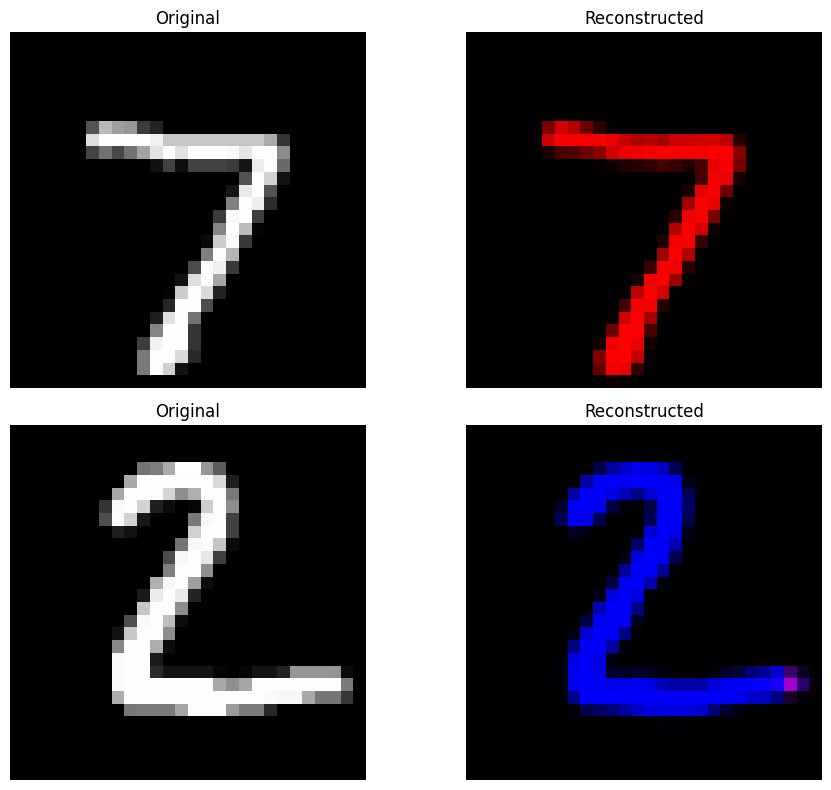

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0240 - val_loss: 0.0255
Epoch 21/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0241 - val_loss: 0.0260
Epoch 22/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0239 - val_loss: 0.0280
Epoch 23/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0239 - val_loss: 0.0271
Epoch 24/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0236 - val_loss: 0.0253
Epoch 25/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0235 - val_loss: 0.0258
Epoch 26/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0236 - val_loss: 0.0262
Epoch 27/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0235 - val_loss: 0.0261
Epoch 28/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0234 - val_loss: 0.0266
Epoch 29/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0233 - val_loss: 0.0254
Epoch 30/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0231 - val_loss: 0.0258
Epoch 31/100
469/469 ━━

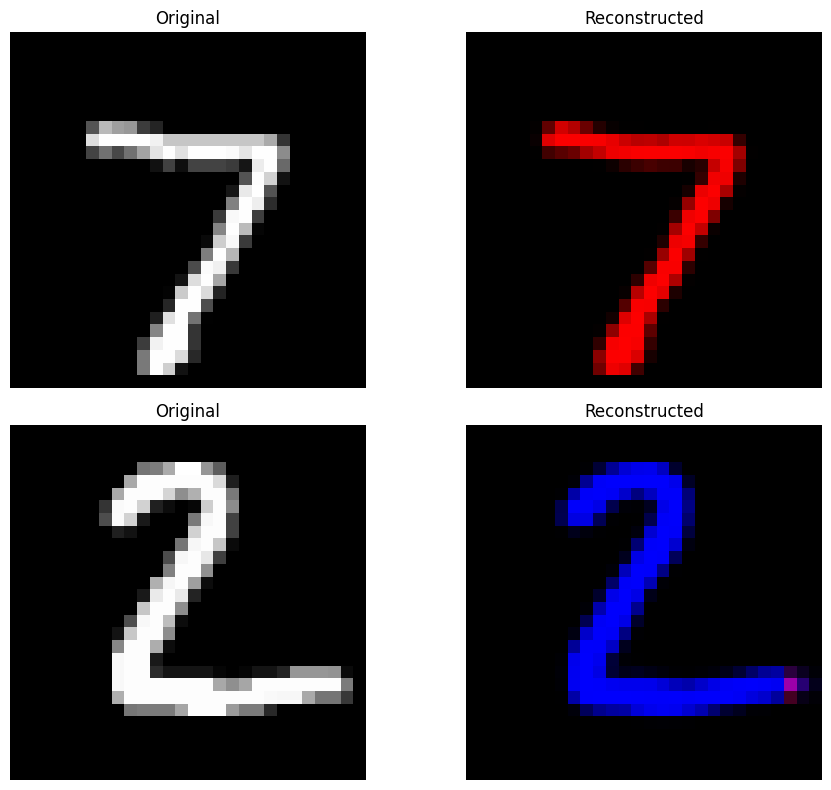

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0228 - val_loss: 0.0254
Epoch 41/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0228 - val_loss: 0.0257
Epoch 42/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0227 - val_loss: 0.0255
Epoch 43/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0228 - val_loss: 0.0255
Epoch 44/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0226 - val_loss: 0.0256
Epoch 45/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0224 - val_loss: 0.0257
Epoch 46/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0226 - val_loss: 0.0255
Epoch 47/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0226 - val_loss: 0.0252
Epoch 48/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0225 - val_loss: 0.0253
Epoch 49/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0224 - val_loss: 0.0258
Epoch 50/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0227 - val_loss: 0.0259
Epoch 51/100
469/469 ━━

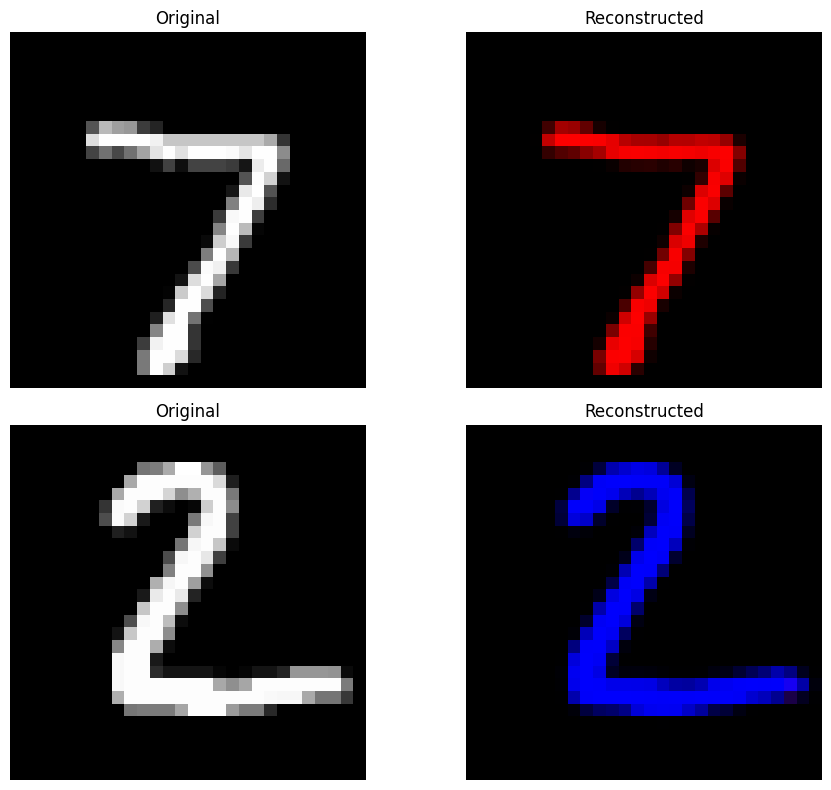

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0223 - val_loss: 0.0264
Epoch 61/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0224 - val_loss: 0.0258
Epoch 62/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0222 - val_loss: 0.0265
Epoch 63/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0223 - val_loss: 0.0256
Epoch 64/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0221 - val_loss: 0.0276
Epoch 65/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0223 - val_loss: 0.0255
Epoch 66/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0221 - val_loss: 0.0259
Epoch 67/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0220 - val_loss: 0.0256
Epoch 68/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0221 - val_loss: 0.0253
Epoch 69/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0225 - val_loss: 0.0252
Epoch 70/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0220 - val_loss: 0.0256
Epoch 71/100
469/469 ━━

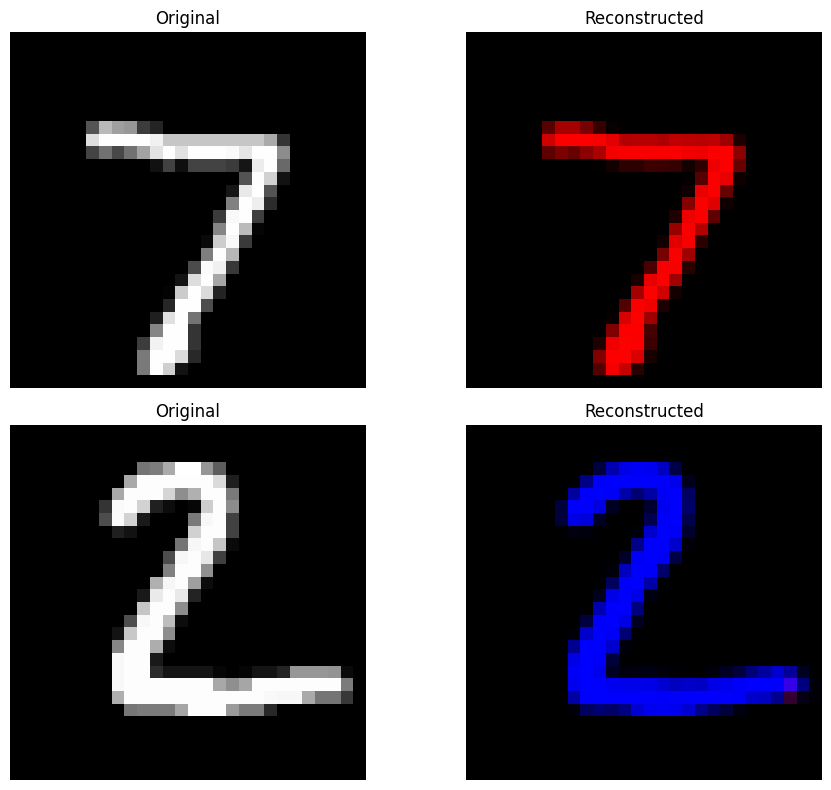

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0218 - val_loss: 0.0258
Epoch 81/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0218 - val_loss: 0.0258
Epoch 82/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0221 - val_loss: 0.0278
Epoch 83/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0219 - val_loss: 0.0258
Epoch 84/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0220 - val_loss: 0.0257
Epoch 85/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0219 - val_loss: 0.0258
Epoch 86/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0218 - val_loss: 0.0259
Epoch 87/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0220 - val_loss: 0.0258
Epoch 88/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0219 - val_loss: 0.0258
Epoch 89/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0222 - val_loss: 0.0259
Epoch 90/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0218 - val_loss: 0.0257
Epoch 91/100
469/469 ━━

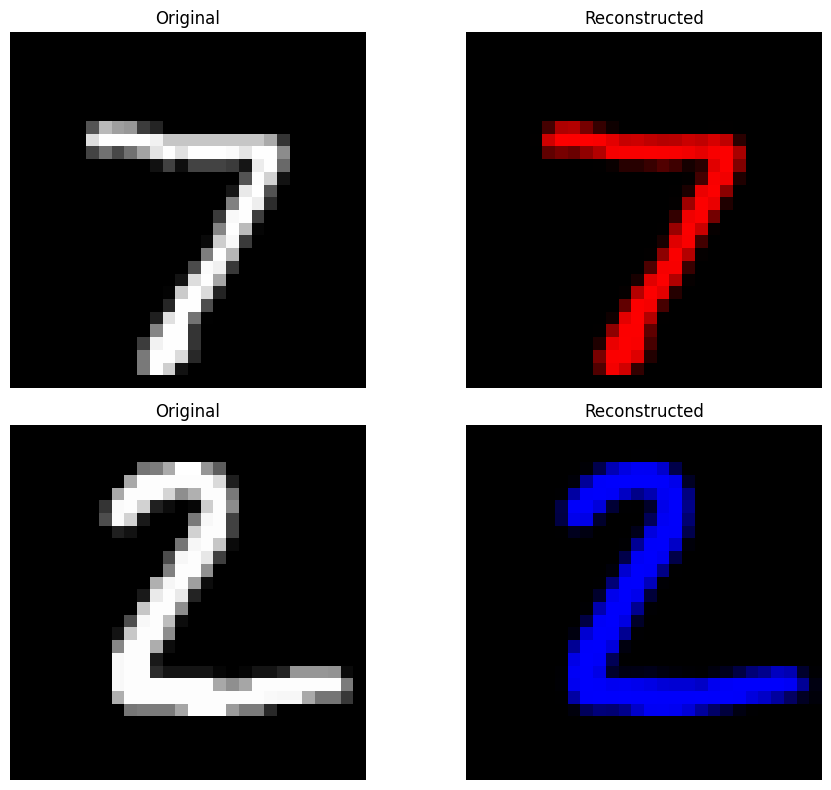

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0218 - val_loss: 0.0271


In [48]:
history = autoencoder.fit(
    x=train_data,
    y=color_train_data, # color_images,
    epochs=100, # Was 50
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, color_test_data),
    callbacks=[callback]
)

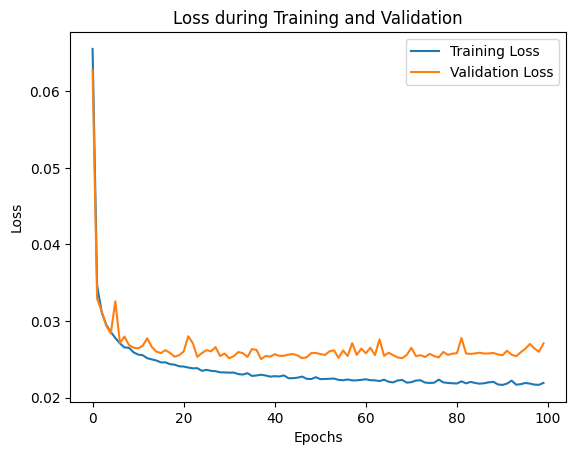

In [49]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
autoencoder.save('model_par_impar_colorido.keras')

Let's predict on our test dataset and display the original image together with the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although not quite the same.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


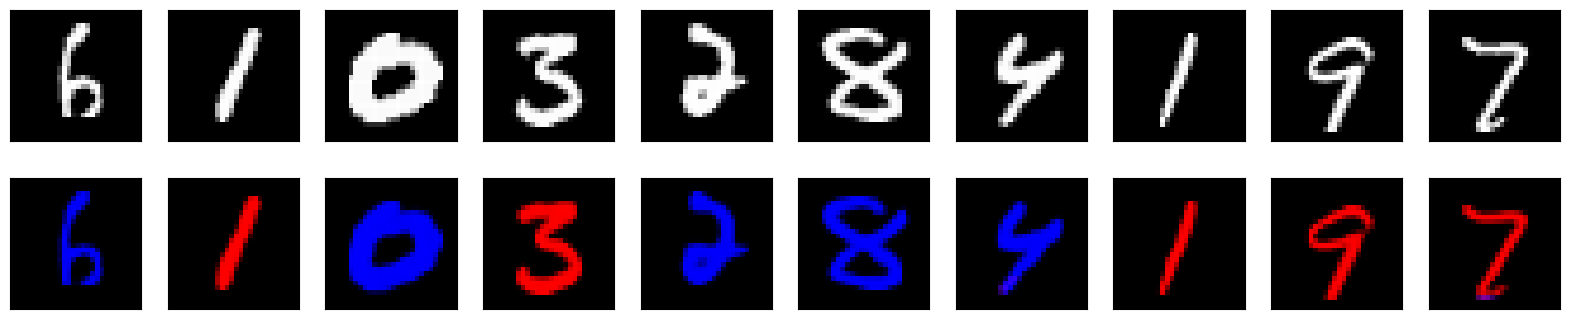

In [50]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


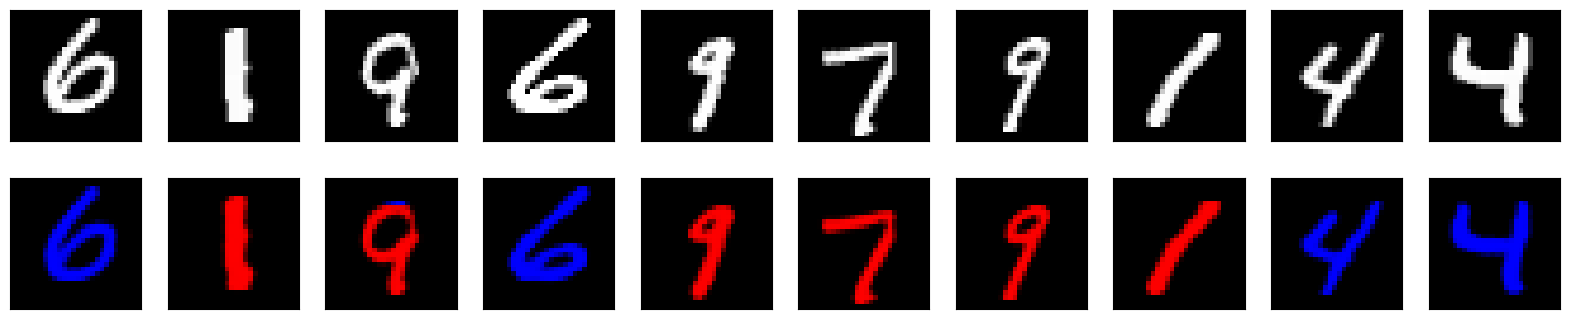

In [7]:
# Open model
model = keras.models.load_model('model_par_impar_colorido.keras')

# Predict
predictions = model.predict(test_data)
display(test_data, predictions)